<a href="https://colab.research.google.com/github/Karkess/Random_LQCD_Junk/blob/main/GNN_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install torch_geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install ace_tools

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


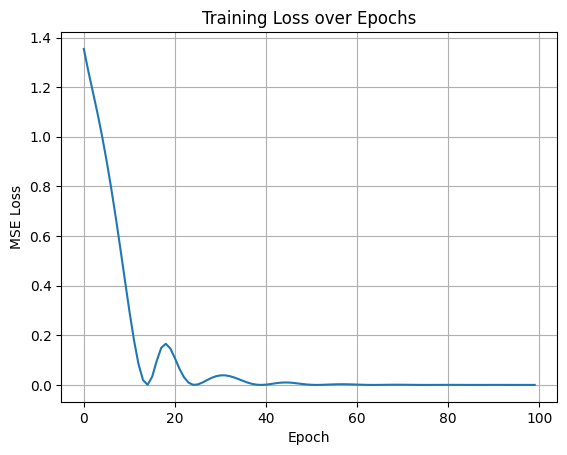

Predicted mass: 1.195568323135376


In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch_geometric.utils import from_networkx

# Generate a 2D lattice scalar field phi^4 theory configuration (mock)
L = 10  # 10x10 lattice
beta = 0.4
lam = 0.1

# Create lattice graph
G = nx.grid_2d_graph(L, L, periodic=False)
G = nx.convert_node_labels_to_integers(G)
pos = {i: (i % L, i // L) for i in range(L * L)}

# Assign scalar field (mock values)
phi = np.random.normal(0, 1, size=(L * L, 1))
nx.set_node_attributes(G, {i: float(phi[i][0]) for i in range(L * L)}, 'x')

# Convert to torch_geometric Data
data = from_networkx(G)
data.x = torch.tensor(phi, dtype=torch.float)
data.y = torch.tensor([1.2], dtype=torch.float)  # mock scalar mass

# Simple GCN for regression
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.lin = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = torch.mean(x, dim=0)  # global mean pooling
        x = self.lin(x)
        return x

# Initialize model, optimizer
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
losses = []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    final_output = model(data)
    print("Predicted mass:", final_output.item())
